TODO (for Amédée):

- Check normalization in Dataset. Not sure what to do we the conversion to tensor in getitem() in `if self.transform:`
> * Normalization changed for environmental covariates (no climatology removed to help the network to learn the annual patterns)
> * Not sure to understand the pb is transformation to tensor


- Is it a good idea to return out in the forward function in 3D (batch, 1, 24), why not 2D (batch, 24)? It would make the loss computation slightly more convininent to write.
> * Good point but I have actually no idea.. We could check by comparing time in loss computation.


OTHER MODIFICATIONS
> * Year added in dataloader & network inputs
> * Change batch size to 256 (usually as big as possible for increased convergence)
> * Add learning rate change strategy
> * Add gradient loss for helping prediction smoothness
> * Add evaluation steps

# Deep Network


In [25]:
# # mount google drive
# from google.colab import drive
# drive.mount("/content/drive/")

In [26]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Define Birddataset


In [27]:
from torch.utils.data import Dataset
from torchvision import transforms

class BirdDataset(Dataset):
    def __init__(self, species = "Buse variable", years = range(1966, 2023), lag_day = 7, transform=False):

      # data_folder = "./drive/MyDrive/DefileCast/data" # for colab
      data_folder = "../data"                        # for local

      # WEATHER DATA ----------------------------
      # Create data xarray (better to handle multi-indexing)
      era5_hourly = pd.read_csv(data_folder+"/era5_hourly.csv", parse_dates=['datetime'])
      era5_hourly["date"] = pd.to_datetime(era5_hourly["datetime"].dt.date)
      era5_hourly['time'] = era5_hourly.datetime.dt.time
      era5_hourly = era5_hourly.drop('datetime', axis=1)
      era5_hourly = era5_hourly.set_index(['date', 'time']).to_xarray() # date and time as distinct indexes

      # Create daily data (with lags)
      era5_daily = era5_hourly.mean(dim="time") # get daily mean
      era5_daily = era5_daily.assign_coords(lag = [0]) # add lag as new coordinate
      # Make all existing variables depend on the new coordinate
      for var in era5_daily.data_vars:
          era5_daily[var] = era5_daily[var].expand_dims({'lag': era5_daily.lag})

      # Shift and merge daily data
      era5_daily_lagged = era5_daily.copy()
      for lag in range(1,lag_day):
        df = era5_daily.shift(date=lag)
        df = df.assign_coords(lag = [lag])
        era5_daily_lagged = era5_daily_lagged.merge(df.copy())

      #  Remove all dates with NaN
      # (-> to guarantee that each item has the same size)
      # (= equivalent to removing date when no lags are available)
      era5_daily_lagged = era5_daily_lagged.dropna(dim="date")

      # check that no NaN values are remaining -> ok !
      # print('Remaining NaN in ERA5 daily :', era5_daily_lagged.isnull().sum())

      # COUNT DATA ----------------------------
      # Read data
      df = pd.read_csv(data_folder+"/all_count_processed.csv", parse_dates=["date", "start", "end"])
      df["duration"] = df["end"] - df["start"]
      df["doy"] = df["date"].dt.day_of_year
      df["year"] = df["date"].dt.year

      # Check that ERA5 values are available for all observations -> ok !
      # Otherwise would need to subset the count dataset
      # print('Number of dates not in ERA5 daily :', len([d for d in df.date.unique() if d not in era5_daily_lagged.date]))

      # Filter data by years
      dfy = df[df["date"].dt.year.isin(years)]

      # Filter data by species
      data_count = dfy[dfy.species==species][["date", "count", "start", "end"]]
      dfys = dfy[[x for x in list(dfy) if x not in ["species", "count"]]].drop_duplicates().merge(data_count, how="left")
      dfys["count"] = dfys["count"].fillna(0)

      # Create mask
      # Corresponding to the fraction of each hour of the day during which the count in question has been happening
      hours_mat = np.repeat(np.arange(24), len(dfys)).reshape( 24, len(dfys))
      startHour = dfys["start"].dt.hour.values + dfys["start"].dt.minute.values/60
      endHour = dfys["end"].dt.hour.values + dfys["end"].dt.minute.values/60
      tmp1 = np.maximum(np.minimum(hours_mat - startHour + 1, 1), 0)
      tmp2 = np.maximum(np.minimum(endHour - hours_mat, 1), 0)
      mask =  np.minimum(tmp1, tmp2)

      # Check mask is never 0
      # mask.sum(axis=0)

      # normalizing
      if transform:
        # era5_daily_lagged = (era5_daily_lagged - era5_daily_lagged.mean(dim = "date")) / era5_daily_lagged.std(dim = "date")
        # era5_hourly = (era5_hourly - era5_hourly.mean(dim = "date")) / era5_hourly.std(dim = "date")
        era5_daily_lagged = (era5_daily_lagged - era5_daily_lagged.mean()) / era5_daily_lagged.std()
        era5_hourly = (era5_hourly - era5_hourly.mean()) / era5_hourly.std()

        dfys["count"] = np.log10(1+dfys["count"])
        dfys["doy"] = dfys["doy"]/365
        dfys["year"] = (dfys["year"] - 2000)/100

      # Assign to self
      self.data = dfys.reset_index(drop=True)
      self.era5_daily = era5_daily_lagged
      self.era5_hourly = era5_hourly
      self.mask = mask
      self.lag_day = lag_day
      self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # index by count/observation
        count = self.data["count"][idx]
        doy = self.data["doy"][idx]
        yr = self.data["year"][idx]
        m = self.mask[:,idx]

        date = self.data["date"][idx]
        era5_h = self.era5_hourly.sel(date = date)
        era5_d = self.era5_daily.sel(date = date)

        # convert to numpy before transformations
        sample = count, yr, doy, era5_h, era5_d, m

        # apply transformations
        if self.transform:
            # to array
            sample = np.array([count]), np.array([yr]), np.array([doy]), era5_h.to_array().values, era5_d.to_array().values, m
            # to tensor
            sample = tuple([torch.FloatTensor(s) for s in sample])

        return sample

## Define dataloader


In [28]:
pd.read_csv("../data/all_count_processed.csv", parse_dates=["date", "start", "end"])

,species,date,start,end,count
0,Accenteur mouchet,1966-10-03,1966-10-03 07:00:00,1966-10-03 11:00:00,2
1,Accenteur mouchet,1966-10-06,1966-10-06 06:30:00,1966-10-06 11:00:00,1
2,Accenteur mouchet,1966-10-12,1966-10-12 07:30:00,1966-10-12 15:30:00,1
3,Accenteur mouchet,1966-10-22,1966-10-22 06:45:00,1966-10-22 11:30:00,1
4,Accenteur mouchet,1969-10-17,1969-10-17 06:45:00,1969-10-17 11:15:00,1
...,...,...,...,...,...
79248,Étourneau sansonnet,2021-11-19,2021-11-19 08:00:00,2021-11-19 09:00:00,23
79249,Étourneau sansonnet,2021-11-19,2021-11-19 10:00:00,2021-11-19 11:00:00,33
79250,Étourneau sansonnet,2021-11-19,2021-11-19 11:00:00,2021-11-19 12:00:00,25
79251,Étourneau sansonnet,2021-11-19,2021-11-19 12:00:00,2021-11-19 13:00:00,8


In [29]:
# split dataset years based on type of data collected
yr_grp = [np.arange(1966, 1992), # size 26
          np.arange(1993, 2013), # size 20
          np.arange(2014, 2021)] # size 7

# Shuffle order
np.random.seed(0)
[np.random.shuffle(y) for y in yr_grp]

# define the cumulative ratio of the training, validation and test dataset.
cum_ratios = np.array([.7, .9])# test size is automatically computed as the fraction left

ytraining = []
yval = []
ytest = []

for y in yr_grp:
    sz = (len(y)*cum_ratios).astype(int)
    y_data = np.split(y, sz)
    ytraining.extend(y_data[0])
    yval.extend(y_data[1])
    ytest.extend(y_data[2])

In [34]:
from torch.utils.data import DataLoader

# Split dataset into train, val & test
train_dataset = BirdDataset(species = "Buse variable", years = ytraining, transform = True)
val_dataset = BirdDataset(species = "Buse variable", years = yval, transform = True)
test_dataset = BirdDataset(species = "Buse variable", years = ytest, transform = True)

# Create dataloader
train_dataloader = DataLoader(train_dataset, batch_size = 256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = 256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size = 256, shuffle=False)

In [68]:
test_dataset = BirdDataset(species = "Buse variable", years = ytest, transform = False)
ds = test_dataset.era5_hourly.copy()

In [69]:
ds['time'].astype(str)

<xarray.DataArray 'time' (time: 24)>
array(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00',
       '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00',
       '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00',
       '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00',
       '20:00:00', '21:00:00', '22:00:00', '23:00:00'], dtype='<U8')
Coordinates:
  * time     (time) object 00:00:00 01:00:00 02:00:00 ... 22:00:00 23:00:00

In [70]:
ds['time'] = pd.to_timedelta(ds['time'].astype(str))

In [71]:
ds

<xarray.Dataset>
Dimensions:                  (date: 20910, time: 24)
Coordinates:
  * date                     (date) datetime64[ns] 1966-09-01 ... 2023-11-30
  * time                     (time) timedelta64[ns] 00:00:00 ... 23:00:00
Data variables:
    temperature_2m           (date, time) float64 297.6 297.3 ... 295.3 294.9
    total_precipitation      (date, time) float64 2.124e-06 0.0 0.0 ... 0.0 0.0
    surface_pressure         (date, time) float64 9.725e+04 ... 9.745e+04
    u_component_of_wind_10m  (date, time) float64 2.676 2.933 ... -4.319 -3.812
    v_component_of_wind_10m  (date, time) float64 6.458 5.901 ... -1.224 -1.896

In [20]:
# TEST
eval_count_obs = []
eval_count_mask = []

for count, yr, doy, era5_hourly, era5_daily, mask in iter(test_dataloader):

    eval_count_obs.append(count)
    eval_count_mask.append(mask)

eval_count_obs = torch.cat(eval_count_obs, dim = 0)
eval_count_mask = torch.cat(eval_count_mask, dim = 0)


In [22]:
yr

tensor([[ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.1400],
        [ 0.

## Define NN model

Ici une architecture simple d'un réseau convolutionnel, hésite pas à jouer avec pour comprendre comment ça marche. La ça transforme juste une série temporelle (à l'heure) de cdtion météo en observations


In [6]:
# Define model architectire
import torch.nn as nn

# Define your model (flexible way)
class Net(nn.Module):
    def __init__(self, nb_features, nb_layer, device):
        super(Net, self).__init__()

        self.nb_features = nb_features
        self.nb_layer = nb_layer
        self.device = device

        nb_features_in_layer = nb_features

        # Add layers as per your requirement
        layers = []
        for n in range(nb_layer):
            layers.append(nn.Conv1d(in_channels = nb_features_in_layer, out_channels=nb_features_in_layer*2, kernel_size = 5, stride = 1, padding = 2, dilation = 1))
            layers.append(nn.BatchNorm1d(num_features = nb_features_in_layer*2))
            layers.append(nn.ReLU())
            nb_features_in_layer *= 2

        self.layers = nn.Sequential(*layers)

        # Add layers as per your requirement
        self.last_layer = nn.Sequential(
                          nn.Conv1d(in_channels = nb_features_in_layer, out_channels=1, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
                          nn.Sigmoid()
                          )

    def forward(self, yr, doy, era5_hourly):
        # Define forward pass

        # ---------------------------
        # Example of a model that only takes doy and era5_hourly
        # and applies distinct layers of 1D convolutions

        # doy repeated to go from (batch, 1) to (batch, 1, 24)
        doy = doy.repeat(1, 24).unsqueeze(1)
        yr = yr.repeat(1, 24).unsqueeze(1)
        # concatenate doy with era_hourly as feature (batch, nfeatures + 1, 24)
        X = torch.cat([era5_hourly, doy, yr], 1)

        out = self.layers(X)
        out = self.last_layer(out)
        out = 5*out # car la dernière couche de sigmoid force 0 < out < 1, making possible to generate count data between 10^0 and 10^5


        ## !!!!!!!! Usually not good practice to instantiate value in Tensor !!!!!!!!!
        # -> it makes the computation of automatic differentiation impossible
        # -> usually better to multiply by some mask
        # -> Here in practice it does not change anything yet
        # # Force count to be zero between 0-? and ?-24 hr
        # out[:,:,:6] = 0
        # out[:,:,21:] = 0
        # Force count to be zero between 0-? and ?-24 hr
        pred_mask = np.array([1 for i in range(24)])
        pred_mask[:6] = 0
        pred_mask[21:] = 0
        pred_mask = torch.FloatTensor(pred_mask).repeat(out.shape[0], 1).unsqueeze(1)
        out = out * pred_mask.to(self.device)

        return out # (batch, 1, 24)

    def loss(self, y_pred, y, mask):

        y_pred_start_to_end = torch.sum(y_pred.squeeze()*mask, dim = 1)

        # Compute a weight for each hour based on which hour of day it is
        # w_hour = ( (torch.arange(24) - 12 )**2+1 )
        # np.sum(mask, axis = 1)
        sum_mask = torch.Tensor([0, 0, 0, 0, 0, 0.58, 48, 740, 1777, 3334, 4086, 3878, 3719, 3543, 3363, 2995, 2378, 1440, 585, 160, 17, 0, 0, 0]).to(self.device)
        w_hour =1/(1 + sum_mask)
        w_hour[6:21] = w_hour[6:21] / sum(w_hour[6:21])

        w_count = torch.sum( w_hour * mask , dim=1)

        loss_rmse = torch.mean((y_pred_start_to_end - y.squeeze()) **2 * w_count)
        loss_grad = torch.mean(torch.diff(count_pred, 1)**2)

        return loss_rmse + loss_grad

In [7]:
model = Net(nb_features = 7, nb_layer = 4, device = "cpu")

count, yr, doy, era5_hourly, era5_daily, mask = next(iter(train_dataloader))
count_pred  = model(yr, doy, era5_hourly)
print(count_pred)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<MulBackward0>)


## Training


In [8]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# if GPU available (cf. GG Colab > Exécution > Modifier le type d'exécution)
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Net(nb_features = 7, nb_layer = 4, device = device)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)  # or any other optimizer
scheduler = StepLR(optimizer, step_size = 1, gamma=0.5)

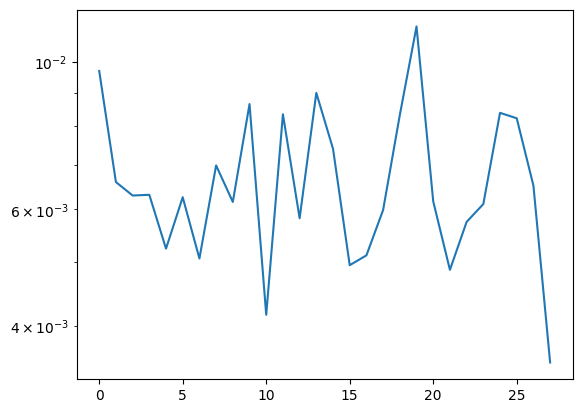

100%|██████████| 11/11 [00:05<00:00,  2.06it/s]

Early stopping: No improvement for 2 epochs.


In [9]:
from tqdm import tqdm
from IPython.display import clear_output

num_epochs = 10
best_val_loss = float("inf")
patience = 2
counter = 0

# Create a new figure
fig = plt.figure()

# Training loop
for epoch in range(num_epochs):
    # TRAINING
    train_loss = []
    model.train()
    for count, yr, doy, era5_hourly, era5_daily, mask in tqdm(iter(train_dataloader)):

        # push to GPU
        count, yr, doy, era5_hourly, era5_daily, mask = count.to(device), yr.to(device), doy.to(device), era5_hourly.to(device), era5_daily.to(device), mask.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        count_pred  = model(yr, doy, era5_hourly)
        loss = model.loss(count_pred, count, mask)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss.append(loss.item())

        # Update the plot
        plt.semilogy(train_loss, c='tab:blue')
        clear_output(wait=True)
        plt.show()
    scheduler.step()

    # VALIDATION
    val_loss = []
    model.eval()
    for count, yr, doy, era5_hourly, era5_daily, mask in tqdm(iter(val_dataloader)):
        # push to GPU
        count, yr, doy, era5_hourly, era5_daily, mask = count.to(device), yr.to(device), doy.to(device), era5_hourly.to(device), era5_daily.to(device), mask.to(device)
        with torch.no_grad():
            count_pred = model(yr, doy, era5_hourly)
            loss = model.loss(count_pred, count, mask)

        # print statistics
        val_loss.append(loss.item())
    val_loss = np.mean(val_loss)

    # Early stopping criterion
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({'state_dict': model.state_dict()}, 'best_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping: No improvement for {} epochs.".format(patience))
            break

In [10]:
# Load the best model for testing
best_model_checkpoint = torch.load('best_model.pth')
model.load_state_dict(best_model_checkpoint['state_dict'])

<All keys matched successfully>

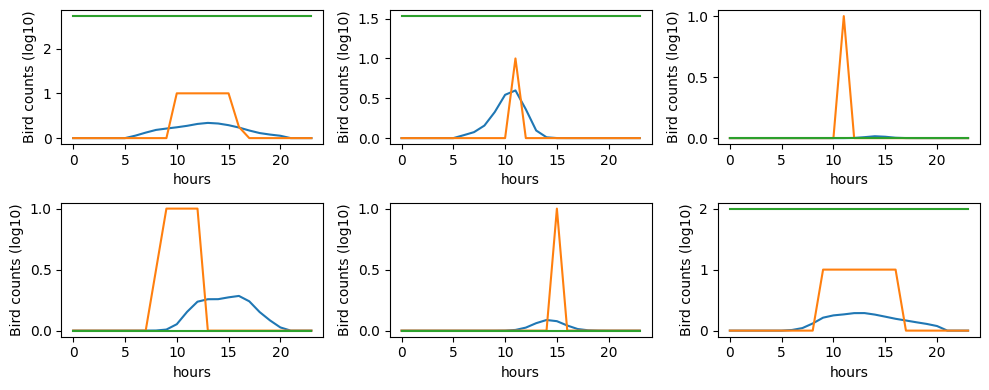

In [14]:
# Example of prediction on train dataset
count, yr, doy, era5_hourly, era5_daily, mask = next(iter(train_dataloader))
# push to GPU
count, yr, doy, era5_hourly, era5_daily, mask = count.to(device), yr.to(device), doy.to(device), era5_hourly.to(device), era5_daily.to(device), mask.to(device)

count_pred  = model(yr, doy, era5_hourly)

y_pred = count_pred.detach().cpu().numpy()
m = mask.detach().cpu().numpy()
count = count.detach().cpu().numpy()

fig, ax = plt.subplots(2,3, figsize = (10, 4), tight_layout=True)
ax = ax.flatten()
for i in range(6):
  ax[i].plot(np.arange(0, 24), y_pred[i,0,:])
  ax[i].plot(np.arange(0, 24), m[i,:])
  ax[i].plot(np.arange(0, 24), count[i].repeat(24))
  ax[i].set_xlabel("hours")
  ax[i].set_ylabel("Bird counts (log10)")

# Evaluation

In [20]:
# TEST
model.eval()
test_count_true = []
test_count_pred = []
test_mask = []

for count, yr, doy, era5_hourly, era5_daily, mask in tqdm(iter(test_dataloader)):
    # push to GPU
    count, yr, doy, era5_hourly, era5_daily, mask = count.to(device), yr.to(device), doy.to(device), era5_hourly.to(device), era5_daily.to(device), mask.to(device)
    with torch.no_grad():
      count_pred  = model(yr, doy, era5_hourly)

      test_count_true.append(count)
      test_count_pred.append(count_pred)
      test_mask.append(mask)

test_count_true = torch.cat(test_count_true, 0)
test_count_pred = torch.cat(test_count_pred, 0)
test_mask = torch.cat(test_mask, 0)

100%|██████████| 6/6 [00:02<00:00,  2.57it/s]


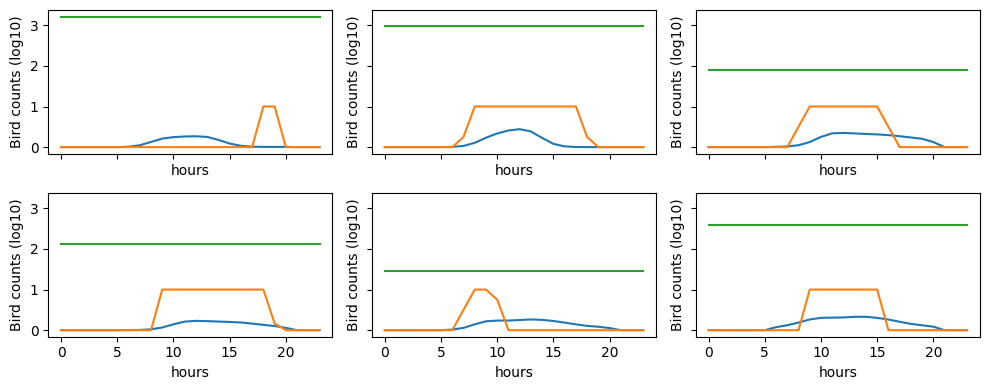

In [22]:
test_count_true = test_count_true.detach().cpu().numpy()
test_count_pred = test_count_pred.detach().cpu().numpy()
test_mask = test_mask.detach().cpu().numpy()

fig, ax = plt.subplots(2,3, figsize = (10, 4), tight_layout=True, sharey = True, sharex= True)
ax = ax.flatten()
k = 0
for i in range(6):
  ax[i].plot(np.arange(0, 24), test_count_pred[k+i,0,:])
  ax[i].plot(np.arange(0, 24), test_mask[k+i,:])
  ax[i].plot(np.arange(0, 24), test_count_true[k+i].repeat(24))
  ax[i].set_xlabel("hours")
  ax[i].set_ylabel("Bird counts (log10)")

Text(0, 0.5, 'Predicted masked counts')

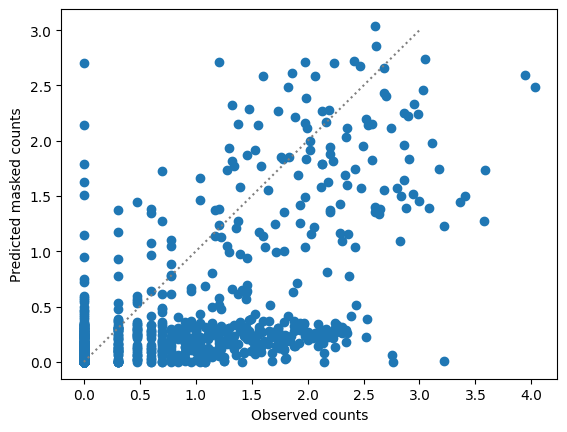

In [26]:
plt.scatter(test_count_true.squeeze(), np.sum(test_count_pred.squeeze()*test_mask, 1))
plt.plot([0,3], [0,3], c='tab:grey', linestyle = ':')
plt.xlabel("Observed counts")
plt.ylabel("Predicted masked counts")
# plt.xlim(0,3)
# plt.xlim(0,3)

In [27]:
import xarray as xr

test_dataset_raw = BirdDataset(species = "Buse variable", years = ytest, transform = False)

predictions = []
for i in range(len(test_dataset_raw)):
  count, year, doy, era5_hourly, era5_daily, mask = test_dataset_raw[i]
  pred = era5_hourly.copy()
  pred = pred.assign(count_pred = ("time", test_count_pred[i,0,:]))
  predictions.append(pred)

predictions = xr.concat(predictions, dim = "date")
predictions = predictions.groupby("date").mean()

[1978 1981 1987 2009 2012 2014]


/usr/local/lib/python3.10/dist-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


Text(0.5, 1.0, 'Mean of predicted counts by time')

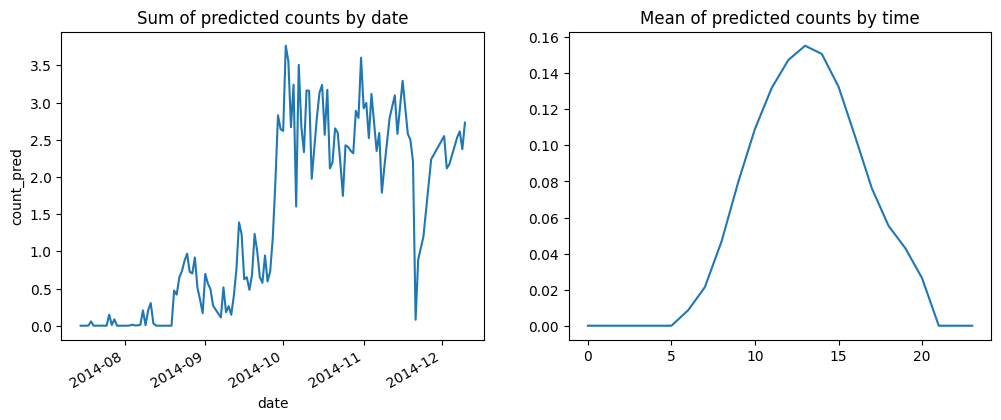

In [29]:
## PREDICTED COUNTS
fig, ax = plt.subplots(1,2, figsize=(12,4))

print(np.unique(predictions.date.dt.year))
predictions.sel(date = predictions.date.dt.year == 2014).sum(dim="time").count_pred.plot(ax=ax[0])
ax[0].set_title("Sum of predicted counts by date")

ax[1].plot(predictions.mean(dim="date").count_pred)
ax[1].set_title("Mean of predicted counts by time")
